<h1>About Project </h1>
In this notebook, we'll see how to use PyTorch to train a classifier to identify the presence of Pneumonia by looking at chest X Ray images. Through this project, we'll get familiar with the basics of transfer learning, PyTorch and convolutional neural networks. This project will culminate in a model that can predict the presence of pneumonia with human radiologist-level accuracy.<br>
<br>
<h2>What is Pneumonia?</h2>
Pneumonia is a lung inflammation caused by a viral or bacterial infection that can range from mild to 
severe cases. This inflammation makes the patient unable to breathe enough oxygen to reach the bloodstream. 
It happens when an infection makes the air sacs (alveoli) in the lungs fill with fluid or pus that might 
affect either one or both lungs. If your doctor thinks you might have pneumonia, a chest X-ray will be
performed to find the infection in the patient's lungs and how far it’s spread.  <a href="https://en.wikipedia.org/wiki/Pneumonia">wikipedia</a><br><br>
<h2>Pytorch</h2>
is An open source deep learning platform that provides a seamless path from research prototyping to production deployment. <a href="https://pytorch.org/">see the oficial web site</a><br>

<h2>Dataset</h2><ul>
<li><h3>Content</h3>
 The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.
</li><br>
<li><h3>Acknowledgements</h3>
Data: <a href="https://data.mendeley.com/datasets/rscbjbr9sj/2">
    https://data.mendeley.com/datasets/rscbjbr9sj/2</a> <br>
License: CC BY 4.0 <br>
Citation: <a href="http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5">http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5 </a><br>
</li>
</ul>

<h2>Import Libraries</h2>
<ul>
    <li>os - for various system commands like changing directories, etc</li>
    <li>glob - for searching for all files using pattern [ used for counting image files] </li>
    <li>torch - Pytorch modules</li>
    <li>OrderedDict</li>
    <li>matplotlib.pyplot - for visualizations</li>
    <li>torchvision -  models, datasets, transforms</li>
</ul>    

In [1]:
# -------------------------------- Pnuemonia Detection ----------------------------
# author @imasy36
# necessary libraries
import os
from glob import glob
import torch
from collections import OrderedDict
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
%matplotlib inline

<h2> Exploring Data </h2>

In [2]:
# changing working directory
path = "/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/"
os.chdir(path)
print(os.getcwd())

print("Folders in directory",end=" - ")
print(os.listdir())

# Total image files in directory
n_files = len([x for x in glob(os.path.join('*','*','*.jpeg'))])
print("Total image files : ",n_files)

/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray
Folders in directory - ['.DS_Store', 'train', 'val', 'test']
Total image files :  5856


Total images: 5856, PNEUMONIA: 4273, NORMAL: 1583


Text(0, 0.5, 'COUNT')

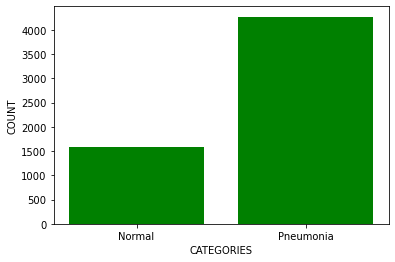

In [3]:
data = {}
data['Normal'] = len([x for x in glob(os.path.join('*','NORMAL','*.jpeg'))])
data['Pneumonia'] = len([x for x in glob(os.path.join('*','PNEUMONIA','*.jpeg'))])
plt.bar( data.keys(),data.values(), color='green')
print("Total images: {}, PNEUMONIA: {}, NORMAL: {}".format(n_files, data['Pneumonia'], data['Normal']))
plt.xlabel("CATEGORIES")
plt.ylabel("COUNT")

<h2>Image pre processing and data iterators</h2>
<h3>Image Pre-Processing and Augmentation</h3>
<img src="https://github.com/imasy36/Machine-Learning-with-python/blob/master/Pneumonia_Detection_densenet/images/image_pre.png?raw=true" />

In [4]:
# transformations on images 
trans_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

trans = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

# Creating datasets using ImageFolder module
test_data = datasets.ImageFolder(os.path.join(path,"test"), transform = trans)
train_data = datasets.ImageFolder(os.path.join(path,"train"), transform = trans_train)
val_data = datasets.ImageFolder(os.path.join(path,"val"), transform = trans)

#creating Data Loaders
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=True)

Images shape :torch.Size([64, 3, 256, 256]) 
Label for 1st image :  PNEUMONIA
{'NORMAL': 0, 'PNEUMONIA': 1}


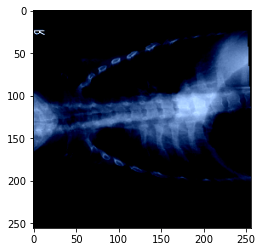

In [5]:
#peek in data
categories = ['NORMAL', 'PNEUMONIA']
img, label = next(iter(train_loader))
print("Images shape :{} ".format(img.size()))
print("Label for 1st image : ",categories[label[0]])
plt.imshow(img[0].numpy().transpose())
#labels
print(train_data.class_to_idx)

<h2>Model Architecture </h2>
In this project, we will fine-tune an existing CNN architecture to classify x-rays images for the
presence of pneumonia. There is no required architecture required for this project, but a
reasonable choice would be using the <strong>DENSENET121</strong> architecture with weights trained on the
ImageNet dataset. Fine-tuning can be performed by freezing our chosen pre-built network and
adding several new layers to the end to train.

<img src="https://github.com/imasy36/Machine-Learning-with-python/blob/master/Pneumonia_Detection_densenet/images/Densenet121.png?raw=true" />

<center><i>One level deeper look at DenseNet-121. Dense Block and Transition Block.</i></center>

In [6]:
# using densenet121 pretrained model 
model = models.densenet121(pretrained=True)
# set no grad as we are not going to modify weights of pretrained model except for last layer
for param in model.parameters():
    param.requires_grad = False
    
in_feature = model.classifier.in_features # in_feature for input to custom layers
print("Input for classifier ",in_feature)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth



Input for classifier  1024


<h3>Custom Classifier</h3>
<ul>
    <li>Layer1 - input:1024, out:256</li>
    <li>ReLU as activation function</li>
    <li>Dropout with probability of 0.2</li>
    <li>Layer2 - input:256, out:32</li>
    <li>ReLU as activation function</li>
    <li>Output layer - Input:32 , out:2</li>
    <li>LogSoftmax</li>
</ul>

In [7]:
# modifying classifier layer
model.classifier = torch.nn.Sequential(OrderedDict([
    ('layer1',torch.nn.Linear(in_feature,256)),
    ('ReLU1', torch.nn.ReLU()),
    ('dp1', torch.nn.Dropout(0.2)),
    ('layer2', torch.nn.Linear(256,32)),
    ('ReLU2', torch.nn.ReLU()),
    ('Output', torch.nn.Linear(32,2)),
    ('LogSoftmax', torch.nn.LogSoftmax(dim=1))    
]))
model.classifier

Sequential(
  (layer1): Linear(in_features=1024, out_features=256, bias=True)
  (ReLU1): ReLU()
  (dp1): Dropout(p=0.2, inplace=False)
  (layer2): Linear(in_features=256, out_features=32, bias=True)
  (ReLU2): ReLU()
  (Output): Linear(in_features=32, out_features=2, bias=True)
  (LogSoftmax): LogSoftmax()
)

In [8]:
total_parameters = sum([p.numel() for p in model.parameters()])
trainable_parameters = sum([p.numel() for p in model.parameters() if p.requires_grad==True])
print("Total parameters : {} | Trainable Parameters : {} ".format(total_parameters,trainable_parameters))

Total parameters : 7224546 | Trainable Parameters : 270690 


In [9]:
#Validation Function
def validation(model, val_loader, gpu):
    steps = 0
    with torch.no_grad():
        model.eval()
        val_loss = 0
        val_acc = 0
        steps += 1
        for images, labels in val_loader:
            if gpu:
                images, labels = images.cuda(), labels.cuda()
            out = model(images)
            loss = loss_fun(out, labels)
            val_loss+=loss.item()*images.size(0)
            output = torch.nn.functional.softmax(out,dim=1)
            val_acc+=(output.max(1)[1] == labels.data).type(torch.FloatTensor).mean()
    print("Validation Loss : {} | Validation accuracy : {} ".format(val_loss/steps, val_acc*100/steps))
    return val_loss/steps, val_acc*100/steps
    

<h3>Detecting GPU</h3>

In [10]:
gpu = torch.cuda.is_available()
print("GPU available : {} ".format(gpu))
if gpu:
    dev = torch.cuda.device_count()
    if dev>1:
        multi_dev = True
    else:
        multi_dev = False
    print("No of devices : {} ".format(dev))
    for _ in range(dev):
        print("Device - ",torch.cuda.get_device_name(_))

GPU available : True 
No of devices : 1 
Device -  Tesla P100-PCIE-16GB


<h3>Training Loss and Optimizer : </h3>
The loss is the negative log likelihood and the optimizer is the Adam optimizer with learning rate = 0.1.

In [11]:
epochs = 15
loss_fun = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [12]:
# transfer to GPU if available
if gpu:
    model = model.to(torch.device('cuda'))
    print("Model is now on GPU")
else:
    print("Model is on CPU")

Model is now on GPU


<h2>Training </h2>
For training, we iterate through the train DataLoader, each time passing one batch through the model. One complete pass through the training data is known as an epoch. After each batch, we calculate the loss and then calculate the gradients of the loss with respect to the model parameters with loss.backward(). This uses autodifferentiation and backpropagation to calculate the gradients.

After calculating the gradients, we call optimizer.step() to update the model parameters with the gradients. This is done on every training batch so we are implementing stochastic gradient descent (or rather a version of it with momentum known as Adam). After the training loop has completed, we start the validation loop.

In [13]:
# Training Model
train_loss = 0
train_acc = 0
loss_list=[]
best={
    'epoch':0,
    'train_loss':0,
    'train_acc':0,
    'val_acc':0,
    'val_loss':0,
    'state_dict':None
}
model.train()
for e in range(epochs):
    steps=0
    for images, labels in train_loader:
        steps+=1
        if gpu:
            images, labels = images.cuda(), labels.cuda()
        output = model(images)
        optimizer.zero_grad()
        loss = loss_fun(output, labels)
        loss.backward()
        optimizer.step()
        train_acc+=(output.max(1)[1]==labels.data).type(torch.FloatTensor).mean()  
        train_loss+=loss.item()*images.size(0)
    print("Epoch {} / {} completed ".format(e+1,epochs))
    print("Training Accuracy : {}".format(train_acc*100/steps))
    print("Training Loss : {}".format(train_loss/steps))
    val_loss, val_acc = validation(model, val_loader, gpu)
    loss_list.append(train_loss/steps)
    print("---------------------------------------------------------------------------------------")
    if (train_acc*100/steps)>=best['train_acc']:
        best['epoch'] = e+1
        best['train_loss'] = train_loss/steps
        best['train_acc'] = train_acc*100/steps
        best['val_loss'] = val_loss
        best['val_acc'] = val_acc
        best['state_dict'] = model.state_dict()
    train_loss = 0
    train_acc = 0

print("Best Epoch: {} with\n training loss: {} | training accuracy: {} |\n validation loss: {} | validation accuracy: {}".
format(best['epoch'], best['train_loss'], best['train_acc'], best['val_loss'], best['val_acc']))
model.load_state_dict(best['state_dict'])

Epoch 1 / 15 completed 
Training Accuracy : 81.78353881835938
Training Loss : 24.518110414830648
Validation Loss : 4.460792064666748 | Validation accuracy : 93.75 
---------------------------------------------------------------------------------------
Epoch 2 / 15 completed 
Training Accuracy : 94.81707000732422
Training Loss : 8.630076835795146
Validation Loss : 4.723204135894775 | Validation accuracy : 87.5 
---------------------------------------------------------------------------------------
Epoch 3 / 15 completed 
Training Accuracy : 95.71265411376953
Training Loss : 6.890823822195937
Validation Loss : 6.957657814025879 | Validation accuracy : 87.5 
---------------------------------------------------------------------------------------
Epoch 4 / 15 completed 
Training Accuracy : 95.17911529541016
Training Loss : 7.41049837193838
Validation Loss : 6.548017501831055 | Validation accuracy : 87.5 
---------------------------------------------------------------------------------------

<All keys matched successfully>

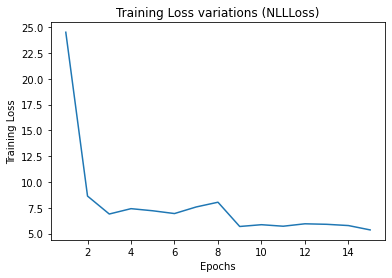

In [14]:
# Training Loss
plt.plot(range(1,len(loss_list)+1), loss_list )
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Training Loss variations (NLLLoss)")
plt.show()

L- Label, P- Prediction


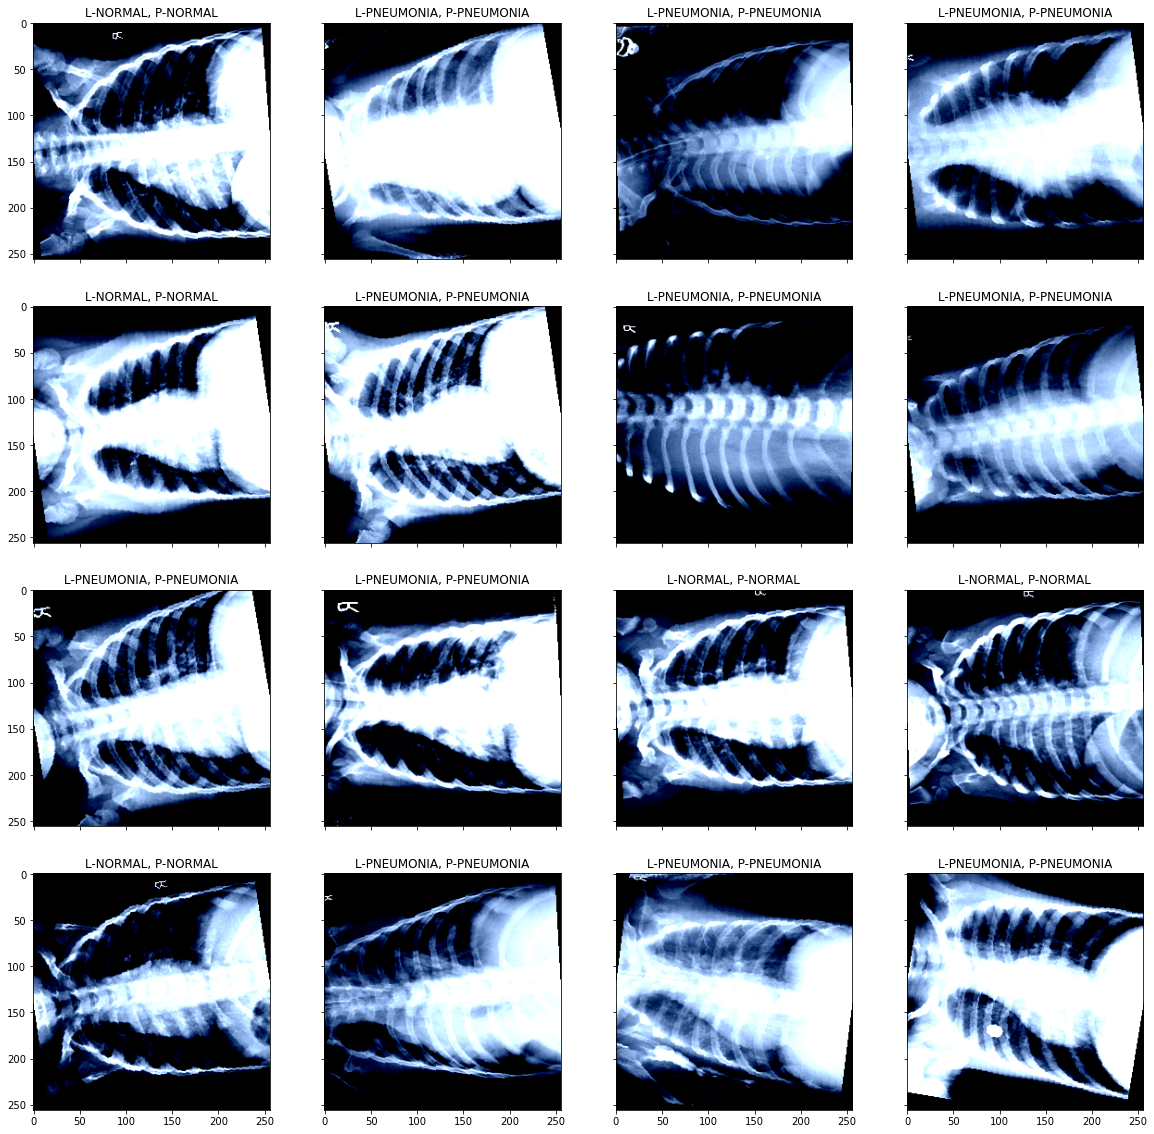

In [15]:
# Hand testing
if gpu:
    model = model.to(torch.device('cpu'))
images, label = next(iter(train_loader))
output = model(images).max(1)[1]
fig, axs = plt.subplots(4,4, sharex=True, sharey=True, figsize=((20, 20)))
img_index=0
print("L- Label, P- Prediction")
for x in range(4):
    for y in range(4):
        axs[x][y].imshow(images[img_index].numpy().transpose())
        axs[x][y].title.set_text("L-{}, P-{}".format(categories[label[img_index]], categories[output[img_index]]))
        img_index+=1
plt.show()

In [16]:
#Testing
model.eval()
steps = 0 
test_loss = 0
test_acc = 0
if gpu:
    model = model.to(torch.device('cuda'))
for images, labels in test_loader:
    steps+=1
    if gpu:
        images, labels = images.cuda(), labels.cuda()
    output = model(images)
    test_loss+=loss_fun(output,labels).item()*images.size(0) 
    test_acc+= (labels.data == output.max(1)[1]).type(torch.FloatTensor).mean()

print("Testing Loss : {} || Testing accuracy : {}".format(test_loss/steps, test_acc*100/steps))


Testing Loss : 23.16521315574646 || Testing accuracy : 88.4375


<h2>Saving the model</h2>
We save the current state_dict of model and optimizer in a file that can be later used to load the model. 

In [17]:
# saving the model
def save_model(file_name):
    save = {
        'Model':'Densenet121',
        'Loss_Function':'NLLLoss',
        'Epochs':epochs,
        'Learning_rate':'0.01',
        'Data':'https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia'
    }
    save['State_dict'] = model.state_dict()
    save['Optimizer'] = optimizer ## save Optimizer if you want to resume training 
    save['Optimizer_state_dict'] = optimizer.state_dict()
    save['Classifier'] = model.classifier
    torch.save(save,file_name)
    print("Model successfully saved in ",file_name)
    
#Loading Model
def load_model(file_name):
    ld = torch.load(file_name)
    model = models.densenet121(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.classifier = ld['Classifier']
    model.load_state_dict(ld['State_dict'])
    optimizer = ld['Optimizer']
    optimizer.load_state_dict(ld['Optimizer_state_dict'])
    return model, optimizer

In [18]:
os.chdir('/kaggle/working')
f_name = 'Pneumoia_Densenet121.pth'
save_model(f_name)

Model successfully saved in  Pneumoia_Densenet121.pth
